In [1]:
# Подготовка данных
# Задание 1 недели

# Обработайте сырые данные по следующей схеме.
#     Почистите данные от ошибок и аномалий.
#     Отбросьте минуты и секунды во времени начала поездки.
#     Нью-Йорк вписан в прямоугольник от -74.25559 до -73.70001 градусов долготы и от 40.49612 до 40.91553 широты.
#     Разбейте этот прямоугольник на 2500 одинаковых прямоугольных областей — по 50 интервалов вдоль каждой оси.
#     Посчитайте количество поездок за каждый час из каждой области.
#     Не забудьте, что если в сырых данных для какой-то пары час-область нет ни одной записи,
#     то в агрегированных данных для неё должен стоять 0.

# 1. Загрузите данные за май 2016 года.

# 2. Проведите фильтрацию: удалите поездки с
#     нулевой длительностью
#     нулевым количеством пассажиров
#     нулевым расстоянием поездки по счётчику
#     координатами начала, не попадающими в прямоугольник Нью-Йорка

# 3. Агрегируйте данные за май 2016 года по часам и областям (можно использовать функцию stats.binned_statistic_2d,
# с которой вы сталкивались в заданиях четвёртого курса).
#  Не забудьте проверить, что идентификаторы, которые вы присваиваете ячейкам, соответствуют приложенному выше файлу.

# 4. Выведите первые строки полученной таблицы с указанием времени, идентификатора зоны и количества поездок.

# 5. Постройте график количества поездок жёлтого такси из ячейки, содержащей Empire State Building.

# 6. Посчитайте, сколько в мае 2016 было пар час-ячейка, для которых не было совершено ни одной поездки.

# **Для сдачи задания этой недели вам нужно агрегировать только данные за май 2016, но, когда задание будет сдано,
# не забудьте запустить ваш агрегирующий скрипт на всех остальных месяцах,
# которые вы собираетесь использовать при прогнозировании.

In [2]:
import pandas as pd
import numpy as np 
from scipy import stats

In [3]:
# данные за май
df = pd.read_csv('data/yellow_tripdata_2016-05.csv', parse_dates=['tpep_pickup_datetime'])
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,1,2016-05-01,2016-05-01 00:17:31,1,3.60,-73.985901,40.768040,1,N,-73.983986,40.730099,1,15.0,0.5,0.5,1.50,0.0,0.3,17.80
1,2,2016-05-01,2016-05-01 00:07:31,1,1.68,-73.991577,40.744751,1,N,-73.975700,40.765469,1,7.5,0.5,0.5,0.88,0.0,0.3,9.68
2,2,2016-05-01,2016-05-01 00:07:01,6,1.09,-73.993073,40.741573,1,N,-73.980995,40.744633,1,6.5,0.5,0.5,1.56,0.0,0.3,9.36
3,2,2016-05-01,2016-05-01 00:19:47,1,4.21,-73.991943,40.684601,1,N,-74.002258,40.733002,1,17.0,0.5,0.5,3.66,0.0,0.3,21.96
4,2,2016-05-01,2016-05-01 00:06:39,1,0.56,-74.005280,40.740192,1,N,-73.997498,40.737564,1,6.0,0.5,0.5,1.46,0.0,0.3,8.76


In [5]:
# загрузка списка квадратов
regions = pd.read_csv('data/regions.csv', sep=';', header=0)
regions.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


In [6]:
# границы города
NY_west = min(regions.west)
NY_east = max(regions.east)
NY_south = min(regions.south)
NY_north = max(regions.north)

# создаем координатную сетку
x = np.linspace(NY_west, NY_east, 51)
y = np.linspace(NY_south, NY_north, 51)

In [7]:
# функция очистки данных
def clear_data(df):
    before = len(df)
    # удаляем записи с нулевым временем поездки
    df.drop(df[df.tpep_pickup_datetime == df.tpep_dropoff_datetime].index, inplace = True)
    # удаляем записи с нулевым количеством пассажиров
    df.drop(df[df.passenger_count == 0].index, inplace = True)
    # удаляем записи с нулевым расстоянием 
    df.drop(df[df.trip_distance == 0].index, inplace = True)
    # удаляем записи не попадающие в заданные границы города
    df.drop(list(
        df.index[
            (df.pickup_longitude < NY_west) | 
            (df.pickup_longitude > NY_east) | 
            (df.pickup_latitude < NY_south) | 
            (df.pickup_latitude > NY_north)]),
        inplace=True)
    after = len(df)
    print(f'Удалено {before - after} записей')

In [8]:
def convert_data(df):
    # Округлим время начала поездки до часа
    df.tpep_pickup_datetime = df.tpep_pickup_datetime.dt.floor(freq='h')
    periods = df.tpep_pickup_datetime.unique()
  
    res = []
    for i in range(len(periods)):
        time_samp = df[df.tpep_pickup_datetime == periods[i]]
        trips = stats.binned_statistic_2d(time_samp.pickup_longitude, time_samp.pickup_latitude, None, statistic='count', bins=[x, y]).statistic.ravel()
        res = res + (list(np.array([list([periods[i]])*2500, range(1,2501), trips]).T))

    return pd.DataFrame(res, columns = ['date', 'start_region', 'trips_count']).astype({'trips_count':'int16'})

In [9]:
# очистка данных от пропусков
clear_data(df)

Удалено 210332 записей


In [10]:
res = convert_data(df).set_index('date')
res.head()

,start_region,trips_count
date,,
2016-05-01,1,0
2016-05-01,2,0
2016-05-01,3,0
2016-05-01,4,0
2016-05-01,5,0


<AxesSubplot:xlabel='date'>

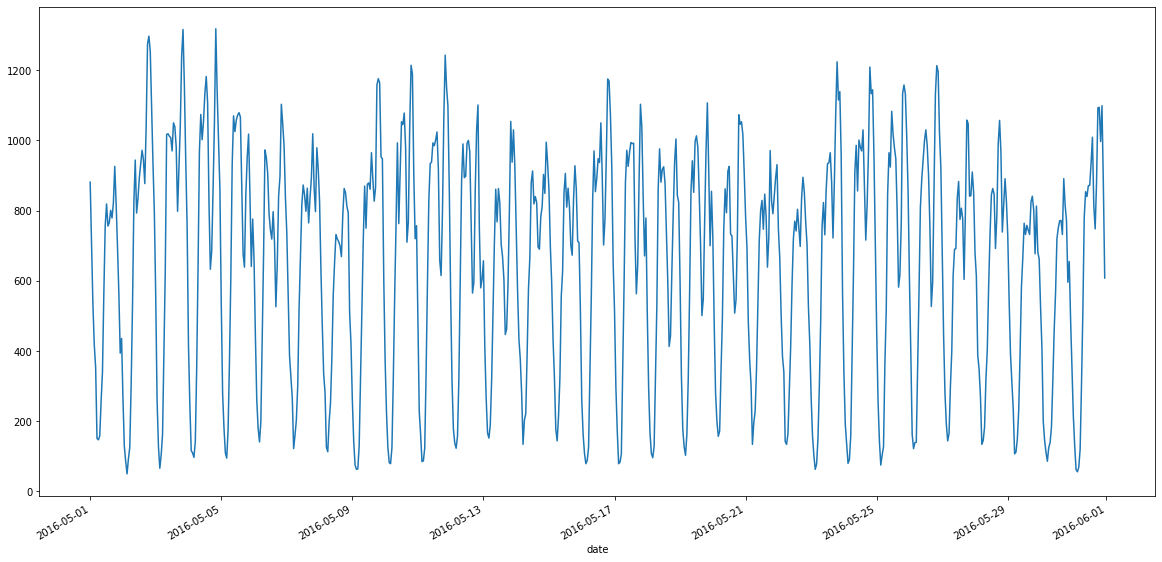

In [11]:
# ESB находится в 1231 квадрате
res[res['start_region']==1231]['trips_count'].plot(figsize=(20,10))

In [12]:
res['trips_count'].value_counts().head()
# первой строкой идет количество ячеек с нулевыми поездками

0    1718238
1      39318
2      15074
3       8979
4       6125
Name: trips_count, dtype: int64